
# Will it rain tomorrow in Australia?


### Table of Contents

* [1. Dataset description](#data)
    * [1.1 Data Exploration](#data_exp)
    * [1.2 Data Analysis](#data_analysis)
    * [1.3 Pre-processing](#pre)
* [2. Classification](#classification)
* [3. Evaluation](#evaluation)







### Task
Predict whether or not it will rain tomorrow in Australia

### Content
This dataset contains daily weather observations from numerous Australian weather stations.

The target variable in this dataset is RainTomorrow.


### Acknowledgements
Observations were drawn from numerous weather stations.
The daily observations are available from http://www.bom.gov.au/climate/data.
Copyright Commonwealth of Australia 2010, Bureau of Meteorology.


In [1]:
# Mount Google drive, where the dataset is stored
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# Pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# Model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sn


# Extra
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import time
from scipy import stats
from sklearn.feature_selection import SelectKBest, chi2
warnings.filterwarnings(action='ignore')
%matplotlib inline

## 1. Dataset description <a id="data"></a>


In [3]:
# Load Dataset
path = '/gdrive/MyDrive/Data Science/UNI/Big Data'
dataset = pd.read_csv('/gdrive/MyDrive/Data Science/UNI/Big Data/weatherAUS.csv')

In [4]:
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
dataset.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


As we can see, most variables have different scales, this could be an issue when modelling a classificator, that is why I'll address this problem later on by rescaling all variables.


### 1.1 Data Exploration <a id="data_exp"></a>



In [7]:
target = 'RainTomorrow'

In [8]:
col = dataset.columns      
print(col)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


In [9]:
# The dataset is quite unbalanced 
features = col[:-1]
dataset[target].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

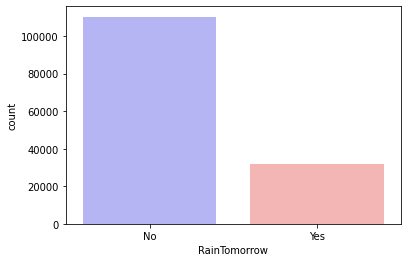

In [10]:
sns.countplot(x=target, data=dataset, palette="bwr")
plt.show()

In [11]:
countRain= len(dataset[dataset[target] == 'Yes'])
countNotRain = len(dataset[dataset[target] == 'No'])
print("It will rain tomorrow: {:.2f}%".format((countRain / (len(dataset[target]))*100)))
print("it WON'T rain tomorrow: {:.2f}%".format((countNotRain / (len(dataset[target]))*100)))

It will rain tomorrow: 21.91%
it WON'T rain tomorrow: 75.84%


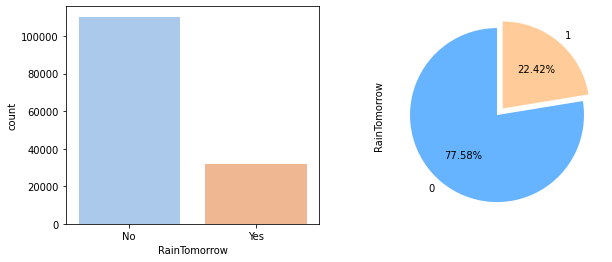

In [12]:
# The Class Distribution
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(10,4))
labels=[0, 1]
sns.countplot(x=dataset.RainTomorrow, data=dataset, palette="pastel",ax=ax[0])
dataset['RainTomorrow'].value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], colors=['#66b3ff','#ffcc99'], 
                                             labels=labels, explode = (0, 0.1), startangle=90)
plt.savefig(path+'/percentage.png')
plt.show()

In [13]:
# RainTomorrow and RainToday values must be transformed from text (Yes, No) to numbers (0, 1)
dataset['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
dataset['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

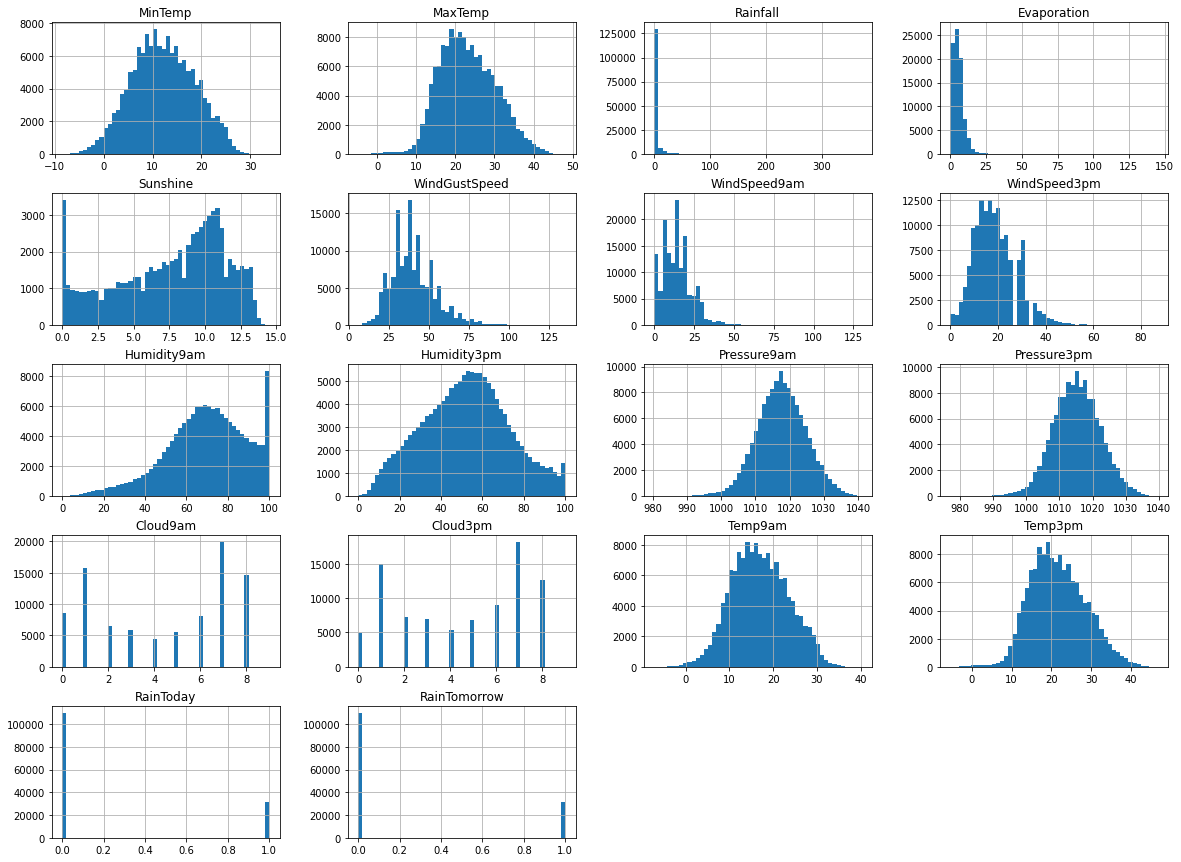

In [14]:
dataset.hist(figsize=(20,15), bins=50)
plt.savefig(path+'/distributions.png')
plt.show()

* Many of these attributes, such as `MinTemp`, `MaxTemp`, `Pressure9am`, and `Pressure3pm`, have bell-shaped distributions.
* `Rainfall` and `Evaporation` are heavily positively skewed.
* `WindGustSpeed`, `WindSpeed9am`, and `WindSpeed3pm` are slightly less skewed to the right.
* `Humidity9am` and `Humidity3pm` are slightly skewed to the left.
* As we said before, these attributes have very different scales. For example, compare `MinTemp` and `Pressure9am`.
* `Cloud9am` and `Cloud3pm` are discrete attributes.
* The mode for `Humidity9am` is 100%. Also, `Humidity3pm` has an usually high number of 100% days given the bell-shaped distribution.

The above highlights the need for feature scaling and the transformation of attributes so they approximate to a normal distribution. Also outliers could be an issue for `Rainfall`, `Evaporation`, `Sunshine`, `Humidity9am`, and `Humidity3pm`.

### Data Visualization

In [15]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Year'] =  pd.DatetimeIndex(dataset['Date']).year

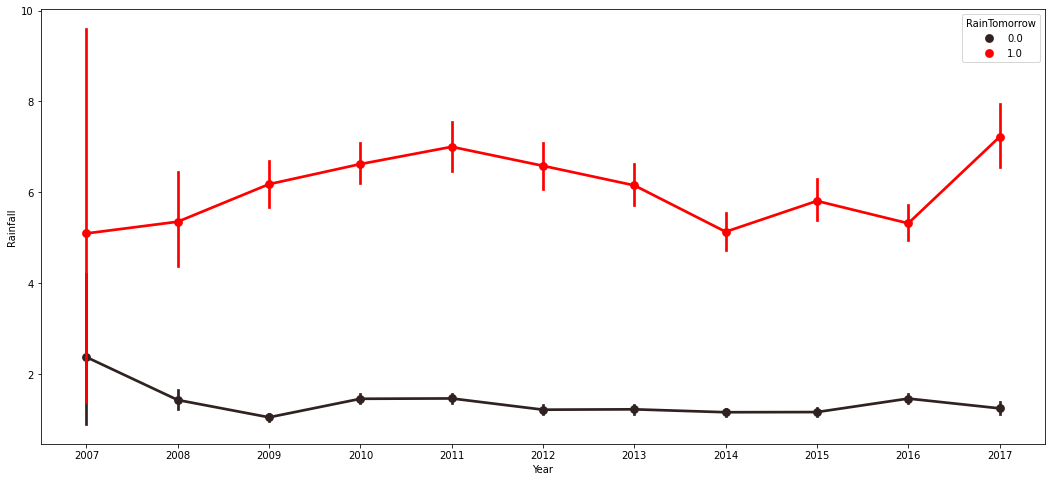

In [16]:
from plotly.offline import iplot
fig, ax =plt.subplots(nrows=1,ncols=1, figsize=(18,8))
sns.pointplot(x="Year",y="Rainfall",data=dataset,hue="RainTomorrow",color="red")
plt.savefig(path+'/rainfall_history.png')
plt.show()

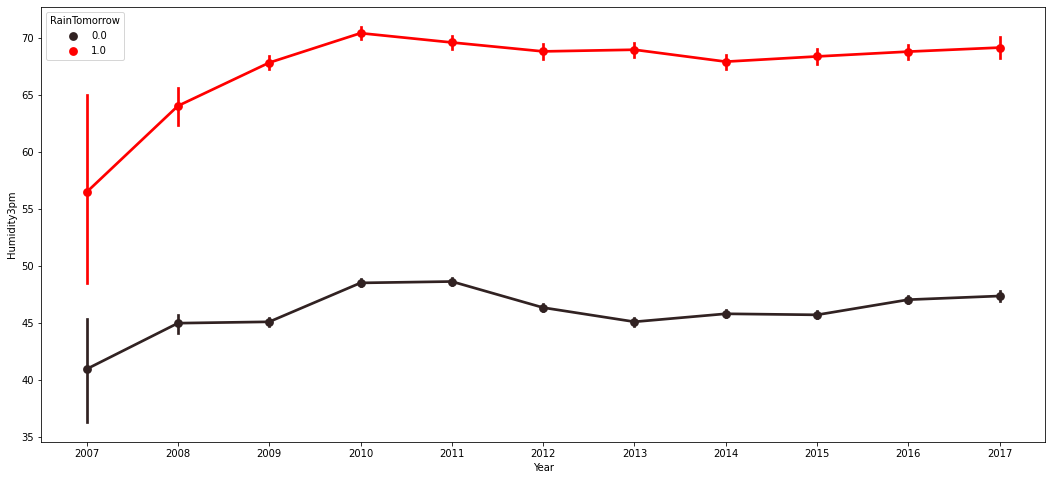

In [17]:
from plotly.offline import iplot
fig, ax =plt.subplots(nrows=1,ncols=1, figsize=(18,8))
sns.pointplot(x="Year",y="Humidity3pm",data=dataset,hue="RainTomorrow",color="red")
plt.savefig(path+'/humdity_history.png')
plt.show()

In [23]:
rain = dataset.loc[dataset['RainToday'] == 1]

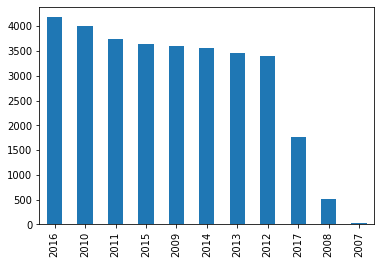

In [24]:
rain['Year'].value_counts(sort=True).plot.bar()
plt.savefig(path+'/rain_year.png')


### 1.2 Data Analysis <a id="data_analysis"></a>



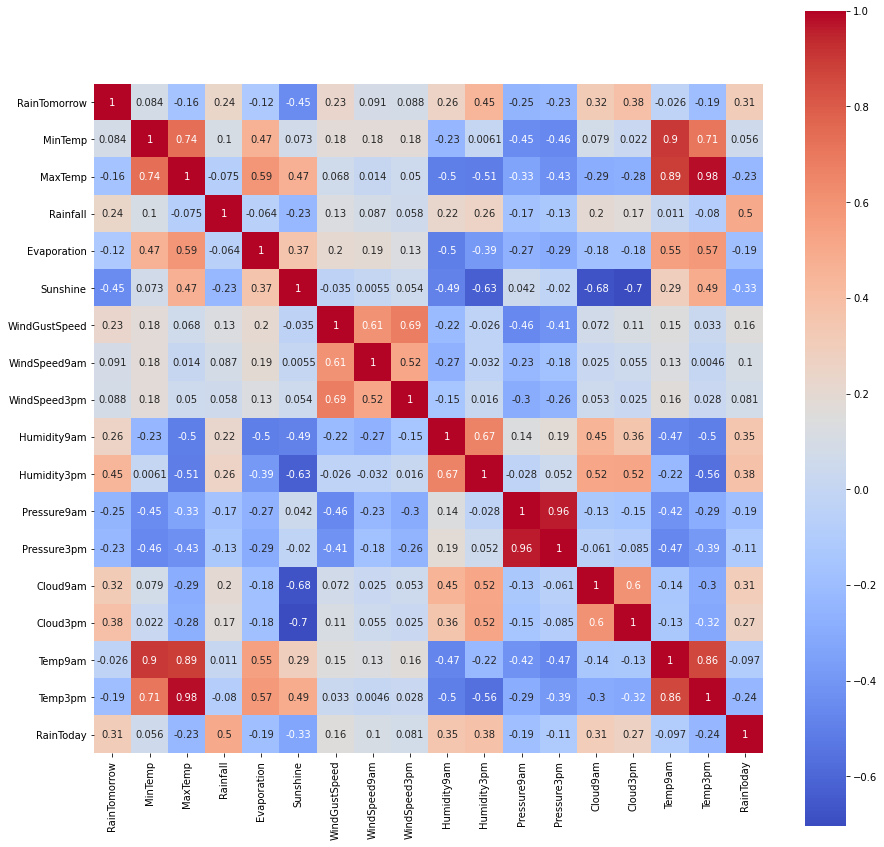

In [25]:
data_map = dataset[[target]]
data_map[features] = dataset[features]
plt.figure(figsize=(15,15))
sns.heatmap(data_map.corr(), annot=True, square=True, cmap='coolwarm')
plt.savefig(path+'/heatmap.png')
plt.show()


* Each pairwise correlation of `MinTemp`, `MaxTemp`, `Temp9am`, and `Temp3pm` has a moderate (0.5 < r < 0.75) to strong (r > 0.75) relationship.
* The strongest association is between `MaxTemp` and `Temp3pm` (r = 0.98) followed by `MinTemp` and `Temp9am` (r = 0.90).
* `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm` are moderately associated with each other (0.5 < r < 0.75).
* There is a moderate relationship between `Humidity9am` and `Humidity3pm` (0.5 < r < 0.75).


#### Missing data


In [26]:
print('Total number of missing values: ')
print(dataset.isnull().sum().sort_values(ascending=False))

Total number of missing values: 
Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
WindSpeed9am      1767
Temp9am           1767
MinTemp           1485
MaxTemp           1261
Location             0
Year                 0
Date                 0
dtype: int64


In [27]:
print('Percentage of missing values: ')
print(round((dataset.isnull().sum().sort_values(ascending=False) / len(dataset)) * 100),2)

Percentage of missing values: 
Sunshine         48.0
Evaporation      43.0
Cloud3pm         41.0
Cloud9am         38.0
Pressure9am      10.0
Pressure3pm      10.0
WindDir9am        7.0
WindGustDir       7.0
WindGustSpeed     7.0
Humidity3pm       3.0
WindDir3pm        3.0
Temp3pm           2.0
RainTomorrow      2.0
Rainfall          2.0
RainToday         2.0
WindSpeed3pm      2.0
Humidity9am       2.0
WindSpeed9am      1.0
Temp9am           1.0
MinTemp           1.0
MaxTemp           1.0
Location          0.0
Year              0.0
Date              0.0
dtype: float64 2


* There are a large number of missing values, particularly for `Sunshine`, `Evaporation`, `Cloud3pm`, and `Cloud9am`. Eventually I'll pick only some variables to use for the classification task, in order to reduce computation time without sacrificing **accuracy**.

### 1.3 Pre-processing <a id="pre"></a>

In [28]:
# The first four columns have less than 62% data, I can ignore these four columns
# We don't need the location column because beause we are interested  whether it will rain in the whole country or not
# We are going to drop the date column too.
df = dataset.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date'],axis=1)
df.shape

(145460, 18)

In [29]:
# Additionally, all the NaN values get dropped
df = df.dropna(how='any')
df.shape

(112925, 18)

In [30]:
#its time to remove the outliers in our data - we are using Z-score to detect and remove the outliers.
z = np.abs(stats.zscore(df._get_numeric_data()))
print(z)
df= df[(z < 3).all(axis=1)]
print(df.shape)

[[0.11756741 0.10822071 0.20666127 ... 0.53828059 0.5334893  1.87866615]
 [0.84180219 0.20684494 0.27640495 ... 0.53828059 0.5334893  1.87866615]
 [0.03761995 0.29277194 0.27640495 ... 0.53828059 0.5334893  1.87866615]
 ...
 [1.44940294 0.23548728 0.27640495 ... 0.53828059 0.5334893  1.67837697]
 [1.16159206 0.46462594 0.27640495 ... 0.53828059 0.5334893  1.67837697]
 [0.77784422 0.4789471  0.27640495 ... 0.53828059 0.5334893  1.67837697]]
(107868, 18)


In [31]:
# Convert categorical variables to integers 
categorical_columns = ['WindGustDir', 'WindDir3pm', 'WindDir9am']

# transform the categorical columns
df = pd.get_dummies(df, columns=categorical_columns)


In [32]:
# As I noted previously, we should standardize the entire dataset
scaler = preprocessing.MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

## 2. Classification<a id="classification"></a>

In [33]:
# We are going to see which are the most important features thanks to SelectKBest, in order to reduce dimensions of the initial dataset
X = df.loc[:,df.columns!='RainTomorrow']
y = df[['RainTomorrow']]
selector = SelectKBest(chi2, k=3)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)]) #top 3 columns

Index(['Rainfall', 'Humidity3pm', 'RainToday'], dtype='object')


In [34]:
# Let's get hold of the important features as assign them as X
X = df[['Humidity3pm','Rainfall','RainToday']] 
y = df[['RainTomorrow']]

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [37]:

# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [DecisionTreeClassifier()],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [2,4,6,8,10,12]},
    {'classifier': [xgb.XGBClassifier()],
     'classifier__max_depth' : [2,4,6,8,10,12]}
]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:  1.8min finished


In [38]:
# Sort the values in ascending orders by rank_test_score
results = pd.DataFrame(best_clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

In [39]:
# We want to get a new column only with the name of the model
import re
param = results['param_classifier'].tolist()
indices = [re.match('^[^\(]+',str(x)).group(0) for x in param]
results['models'] = indices
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_classifier__criterion,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,models
52,2.412557,0.018763,0.045835,0.001777,"XGBClassifier(base_score=0.5, booster='gbtree'...",NaN,NaN,NaN,NaN,2,"{'classifier': XGBClassifier(base_score=0.5, b...",0.843994,0.841014,0.840474,0.842792,0.838819,0.841419,0.001807,1,XGBClassifier
53,3.517772,0.033005,0.071469,0.003037,"XGBClassifier(base_score=0.5, booster='gbtree'...",NaN,NaN,NaN,NaN,4,"{'classifier': XGBClassifier(base_score=0.5, b...",0.843597,0.840683,0.840011,0.842726,0.838819,0.841167,0.001756,2,XGBClassifier
48,0.062378,0.009409,0.005783,0.000051,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,entropy,6,{'classifier': DecisionTreeClassifier(ccp_alph...,0.844259,0.840220,0.839216,0.841997,0.837892,0.840717,0.002221,3,DecisionTreeClassifier
42,0.059113,0.004071,0.005572,0.000075,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,NaN,NaN,gini,6,{'classifier': DecisionTreeClassifier(ccp_alph...,0.844590,0.840418,0.838885,0.841401,0.837494,0.840558,0.002416,4,DecisionTreeClassifier
16,0.334776,0.021672,0.004814,0.000379,"LogisticRegression(C=1.0, class_weight=None, d...",0.233572,l1,liblinear,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.841610,0.839558,0.839613,0.842461,0.839150,0.840478,0.001309,5,LogisticRegression


In [40]:
# New Dataset, for each model we only keep the one that performed the best
top_k = results.groupby('models').first()
top_k.sort_values(by='rank_test_score', inplace=True)
top_k

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_classifier__criterion,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
models,,,,,,,,,,,,,,,,,,,
XGBClassifier,2.412557,0.018763,0.045835,0.001777,"XGBClassifier(base_score=0.5, booster='gbtree'...",NaN,None,None,None,2.0,"{'classifier': XGBClassifier(base_score=0.5, b...",0.843994,0.841014,0.840474,0.842792,0.838819,0.841419,0.001807,1
DecisionTreeClassifier,0.062378,0.009409,0.005783,0.000051,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",NaN,None,None,entropy,6.0,{'classifier': DecisionTreeClassifier(ccp_alph...,0.844259,0.840220,0.839216,0.841997,0.837892,0.840717,0.002221,3
LogisticRegression,0.334776,0.021672,0.004814,0.000379,"LogisticRegression(C=1.0, class_weight=None, d...",0.233572,l1,liblinear,None,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.841610,0.839558,0.839613,0.842461,0.839150,0.840478,0.001309,5


In [41]:
xgb_clas = top_k.iloc[0]['param_classifier']
dec_tree = top_k.iloc[1]['param_classifier']
log_reg = top_k.iloc[2]['param_classifier']

In [54]:
log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
t0=time.time()
xgb_clas.fit(X_train, y_train)
y_pred = xgb_clas.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.839220048824202
Time taken : 1.8702723979949951


In [43]:
t0=time.time()
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.828651772194926
Time taken : 0.07153439521789551


In [44]:
t0=time.time()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

Accuracy : 0.8373659652050307
Time taken : 0.2183067798614502


## 3. Evaluation <a id="evaluation"></a>

We are going to evaluate the best model in terms of accuracy, **XGBoost** , and see how well it actually performs.

In [45]:
from sklearn.model_selection import cross_val_predict
weather_labels_pred = cross_val_predict(xgb_clas, X_train, y_train, cv=3)

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, weather_labels_pred)

array([[57573,  2305],
       [ 9694,  5935]])

In [47]:
# precision = TP / (TP + FP) (the accuracy of positive predictions)
# TP is the number of true positives, and FP is the number of false positives
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, weather_labels_pred, average='binary', pos_label=1) 

0.7202669902912622

In [48]:
# recall = TP / (TP + FN)
recall_score(y_train, weather_labels_pred, average='binary', pos_label=1) 

0.3797427858468232

When the model predicts it will rain tomorrow, it is correct about 72% of the time. Moreover, it correctly classifies 37% of instances in the training set where RainTomorrow is equal to Yes (i.e., by predicting Yes). Or, stated alternatively, 63% of the time the model predicts No for RainTomorrow when it should be Yes.

These numbers may seem disappointing, but at least the model is correctly predicting nearly 40% of Yes instances.

In [49]:
!pip install plot_metric

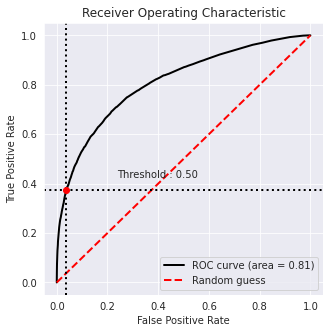

In [51]:
from sklearn import metrics

y_pred = xgb_clas.predict_proba(X_test)
y_pred = y_pred[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
before_importance_scores=pd.DataFrame(columns=["scores"])

before_importance_scores.loc["XGboost Classifier"]=roc_auc

from plot_metric.functions import BinaryClassification

bc = BinaryClassification(y_test, y_pred, labels=["0", "1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.savefig(path+'/ROC_xgb.png')
plt.show()